In [1]:
# https://www.kaggle.com/mathormad/inceptionv3-baseline-lb-0-379/code
# fork of scratch8, 29

In [2]:
%matplotlib inline
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
import keras_metrics

import warnings
warnings.filterwarnings("ignore")
SIZE = 512

Using TensorFlow backend.


In [3]:
# https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric/notebook
import tensorflow as tf

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1) + (1 - K.mean(f1))

In [4]:
# Load dataset info
path_to_train = '../data/train/'
data = pd.read_csv('../data/train.csv')
# path_to_external_data = '../data/external_data/external_data_1/'
# edata = pd.read_csv('../data/external_data.csv')

In [5]:
data.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
train_dataset_info = []

for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
    
# for name, labels in zip(edata['id'], edata['labels'].str.strip('[]')):
#     labels = labels.split(',')
#     train_dataset_info.append({
#         'path':os.path.join(path_to_external_data, name),
#         'labels':np.array([int(label) for label in labels])})
    
train_dataset_info = np.array(train_dataset_info)

In [7]:
train_dataset_info

array([{'path': '../data/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])},
       {'path': '../data/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', 'labels': array([7, 1, 2, 0])},
       {'path': '../data/train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([5])},
       ...,
       {'path': '../data/train/fff189d8-bbab-11e8-b2ba-ac1f6b6435d0', 'labels': array([7])},
       {'path': '../data/train/fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([25,  2, 21])},
       {'path': '../data/train/fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0', 'labels': array([2, 0])}],
      dtype=object)

In [8]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)
#                     image = tdi[i+start]
#                     image = cv2.resize(image, (shape[0], shape[1]))
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels

    def load_image(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image1 = np.stack((
            np.array(image_red_ch),
            np.array(image_green_ch), 
            np.array(image_blue_ch)), -1)
        w, h = 512, 512
#         zero_data = np.zeros((h, w), dtype=np.uint8)
#         image2 = np.stack((
#             np.array(image_red_ch),
#             np.array(image_green_ch), 
#             np.array(image_yellow_ch)), -1)
#         image3 = np.stack((
#             np.array(image_yellow_ch),
#             np.array(image_green_ch), 
#             np.array(image_blue_ch)), -1)
# #         print(image1.shape, image2.shape)
#         image = np.vstack((image1, image2, image3))
#         print(image.shape)
        image =image1
#         image = canny_image4(image1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image
    
    def load_image2(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image1 = np.stack((
            np.array(image_red_ch),
            np.array(image_green_ch), 
            np.array(image_blue_ch)), -1)
        w, h = 512, 512
#         zero_data = np.zeros((h, w), dtype=np.uint8)
#         image2 = np.stack((
#             np.array(image_red_ch),
#             np.array(image_green_ch), 
#             np.array(image_yellow_ch)), -1)
#         image3 = np.stack((
#             np.array(image_yellow_ch),
#             np.array(image_green_ch), 
#             np.array(image_blue_ch)), -1)
# #         print(image1.shape, image2.shape)
#         image = np.vstack((image1, image2, image3))
#         print(image.shape)
        image =image1
#         image = canny_image4(image1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image
    
    def augment2(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Affine(rotate=0),
                    iaa.Affine(rotate=90),
                    iaa.Affine(rotate=180),
                    iaa.Affine(rotate=270),
                    iaa.Flipud(0.5),
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
                    iaa.ContrastNormalization((0.75, 1.5)),
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the
                    # pixels.
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug


In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Input, Conv2D
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

In [10]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
    bn = BatchNormalization(name='bn1')(input_tensor)
    x = base_model(bn)
    x = GlobalAveragePooling2D(name='cam')(x)
#     x = Conv2D(32, kernel_size=(1,1), activation='relu', name='conv1')(x)
#     x = Flatten()(x)
#     x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [11]:
# warm up model
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=28)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 512, 512, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
_________________________________________________________________
cam (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 28)                28700     
Total para

In [12]:
model.compile(loss=f1_loss,
            optimizer=Adam(lr=1e-4),
            metrics=[f1])
model.load_weights('../cache/IV3-34-maximus.h5')

In [13]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

# def load_image(path):
#     img_path = sys.argv[1]
#     img = image.load_img(img_path, target_size=(224, 224))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = preprocess_input(x)
#     return x

def load_image(path):
    return data_generator.load_image(path, (512,512,3))
    
def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
#     conv_output = input_model.get_layer(layer_name).output
    conv_output = input_model.get_layer(layer_name).get_output_at(-1)
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (512, 512), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def grad_cam2(input_model, image, category_index, layer_name):
    model = Sequential()
    model.add(input_model)

    nb_classes = 28
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    model.add(Lambda(target_layer,
                     output_shape = target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)
#     conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    conv_output = [l for l in model.layers[0].layers if l.name is layer_name][0].get_output_at(-1)
    print(conv_output.shape)
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (512, 512))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

In [14]:
image = load_image(train_dataset_info[1]['path'])
preprocessed_input = image[np.newaxis]

In [15]:
train_dataset_info[0]['path']

'../data/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0'

In [16]:
preprocessed_input.shape

(1, 512, 512, 3)

In [17]:
score_predict = model.predict(preprocessed_input)[0]
# draw_predict.append(score_predict)
label_predict = np.arange(28)[score_predict>=0.2]

In [18]:
label_predict[0]

0

In [19]:
# cam = grad_cam(model, preprocessed_input, label_predict[0], "inception_v3")
# cv2.imwrite("../cache/gradcam-my.png", cam)

In [21]:
# cam.shape

In [22]:
# cv2.imwrite("../cache/gradcam-my.jpg", cam)

In [23]:
# heat = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
# heat = np.float32(heat) + np.float32(image)
# heat = 255 * cam / np.max(heat)
# cv2.imwrite("../cache/gradcam-my.png", cam)

In [24]:
# jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
# jetcam = (np.float32(jetcam) + image) / 2
# cv2.imwrite('../cache/gradcam2.png', np.uint8(jetcam))

In [25]:
layer_name = 'cam'
input_img_data = preprocessed_input

In [26]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

In [27]:
layer_dict

{'bn1': <keras.layers.normalization.BatchNormalization at 0x7f807177b438>,
 'cam': <keras.layers.pooling.GlobalAveragePooling2D at 0x7f806f9f75c0>,
 'dense_1': <keras.layers.core.Dense at 0x7f806f9b5128>,
 'dense_2': <keras.layers.core.Dense at 0x7f80709c4390>,
 'dropout_1': <keras.layers.core.Dropout at 0x7f80709c4b70>,
 'inception_v3': <keras.engine.training.Model at 0x7f80717905f8>}

In [28]:
def normalize2(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


In [29]:
input_img = model.input

In [30]:
import time
from tqdm import tqdm_notebook
kept_filters = []
for filter_index in tqdm_notebook(range(200)):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
#     print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize2(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
#     if K.image_data_format() == 'channels_first':
#         input_img_data = np.random.random((1, 3, img_width, img_height))
#     else:
#         input_img_data = np.random.random((1, img_width, img_height, 3))
    
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

#         print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
#     print('Filter %d processed in %ds' % (filter_index, end_time - start_time))


HBox(children=(IntProgress(value=0, max=200), HTML(value='')))

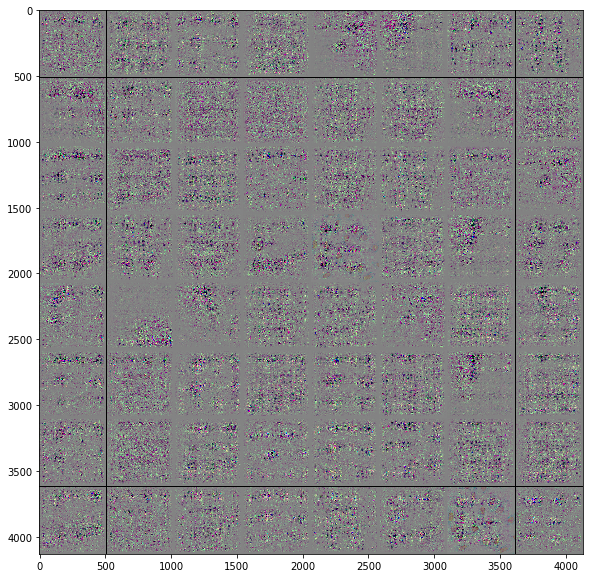

In [32]:
# we will stich the best 64 filters on a 8 x 8 grid.
n = 8
img_width = 512
img_height = 512

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
#         print(i*n+j)
        img, loss = kept_filters[i * n + j]
        width_margin = (img_width + margin) * i
        height_margin = (img_height + margin) * j
        stitched_filters[
            width_margin: width_margin + img_width,
            height_margin: height_margin + img_height, :] = img
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(stitched_filters)

In [33]:
len(stitched_filters)

4131

In [40]:
n = 8
image = np.zeros((512,512,3))
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        image = image + img
img = img/64

In [41]:
img.shape

(512, 512, 3)

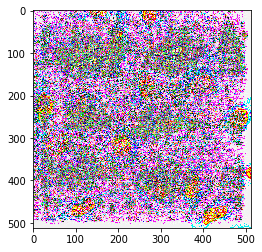

In [42]:
plt.imshow(img)

In [15]:
# create callbacks list
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

epochs = 10; batch_size = 16
checkpoint = ModelCheckpoint('../cache/IV3-34-maximus.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6)
callbacks_list = [checkpoint, early, reduceLROnPlat]


In [16]:

# split data into train, valid
indexes = np.arange(train_dataset_info.shape[0])
np.random.shuffle(indexes)
train_indexes, valid_indexes = train_test_split(indexes, test_size=0.15, random_state=8)

# create train and valid datagens
train_generator = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
validation_generator = data_generator.create_train(
    train_dataset_info[valid_indexes], 32, (SIZE,SIZE,3), augument=True)


In [17]:
# warm up model
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=28)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 512, 512, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 14, 14, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 28)                28700     
Total para

In [18]:


for layer in model.layers:
    layer.trainable = False
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
model.layers[-4].trainable = True
# model.layers[-5].trainable = True
# model.layers[-6].trainable = True

In [19]:
# labels = np.zeros((28))
# labels[0] = 1
model.compile(
    loss=f1_loss, 
    optimizer=Adam(1e-03),
    metrics=[f1])
# model.summary()

In [20]:
model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    validation_data=validation_generator,
    validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=2, 
    verbose=1)

Epoch 1/2
1651/1651 [==============================] - 590s 357ms/step - loss: 1.1123 - f1: 0.0432 - val_loss: 1.1623 - val_f1: 0.0262
Epoch 2/2
1651/1651 [==============================] - 567s 344ms/step - loss: 1.0942 - f1: 0.0598 - val_loss: 1.2361 - val_f1: 0.0353


In [21]:
# train all layers
epochs=120
for layer in model.layers:
    layer.trainable = True
model.compile(loss=f1_loss,
            optimizer=Adam(lr=1e-4),
            metrics=[f1])
model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    validation_data=validation_generator,
    validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=epochs, 
    verbose=1,
    callbacks=callbacks_list)

Epoch 1/120
1651/1651 [==============================] - 975s 591ms/step - loss: 0.9865 - f1: 0.1671 - val_loss: 0.8538 - val_f1: 0.2857

Epoch 00001: val_loss improved from inf to 0.85385, saving model to ../cache/IV3-34-maximus.h5
Epoch 2/120
1651/1651 [==============================] - 958s 580ms/step - loss: 0.9035 - f1: 0.2369 - val_loss: 0.8483 - val_f1: 0.2926

Epoch 00002: val_loss improved from 0.85385 to 0.84827, saving model to ../cache/IV3-34-maximus.h5
Epoch 3/120
1651/1651 [==============================] - 965s 584ms/step - loss: 0.8761 - f1: 0.2533 - val_loss: 0.7978 - val_f1: 0.3238

Epoch 00003: val_loss improved from 0.84827 to 0.79781, saving model to ../cache/IV3-34-maximus.h5
Epoch 4/120
1651/1651 [==============================] - 984s 596ms/step - loss: 0.8591 - f1: 0.2646 - val_loss: 0.8129 - val_f1: 0.3201

Epoch 00004: val_loss did not improve from 0.79781
Epoch 5/120
1651/1651 [==============================] - 965s 584ms/step - loss: 0.8455 - f1: 0.2750 - v

In [22]:
# Create submit
submit = pd.read_csv('../data/sample_submission.csv')
predicted = []
draw_predict = []
# model = create_model(
#     input_shape=(SIZE,SIZE,3), 
#     n_out=28)
# for layer in model.layers:
#     layer.trainable = True
# model.compile(loss=f1_loss,
#             optimizer=Adam(lr=1e-4),
#             metrics=[f1])
model.load_weights('../cache/IV3-34-maximus.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('../data/test/', name)
    image = data_generator.load_image(path, (SIZE,SIZE,3))/255.
    score_predict = model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
# np.save('../cache/draw_predict_InceptionV3-30.npy', score_predict)
# submit.to_csv('../submissions/submit_InceptionV3.csv', index=False)

100%|██████████| 11702/11702 [08:29<00:00, 22.97it/s]


In [23]:
submit.to_csv('../submissions/sub34-max.csv', index=False)

In [24]:
#https://stackoverflow.com/questions/1855095/how-to-create-a-zip-archive-of-a-directory
def backup_project_as_zip(project_dir, zip_file):
    assert(os.path.isdir(project_dir))
    assert(os.path.isdir(os.path.dirname(zip_file)))
    shutil.make_archive(zip_file.replace('.zip',''), 'zip', project_dir)
    pass

In [25]:
import datetime, shutil
now = datetime.datetime.now()
print(now)
PROJECT_PATH = '/home/watts/lal/Kaggle/kagglehp/scripts_nbs'
backup_project_as_zip(PROJECT_PATH, '../cache/code.scripts_nbs.%s.zip'%now)

2018-11-24 22:57:07.641600


In [26]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub34-max.csv -m ""

100%|████████████████████████████████████████| 479k/479k [00:14<00:00, 34.4kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationCPU times: user 371 ms, sys: 196 ms, total: 567 ms
Wall time: 17.5 s


In [15]:
# Create submit

submit = pd.read_csv('../data/sample_submission.csv')
predicted = []
draw_predict = []
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=28)
for layer in model.layers:
    layer.trainable = True
model.compile(loss=f1_loss,
            optimizer=Adam(lr=1e-4),
            metrics=[f1])
model.load_weights('../cache/IV3-34-maximus.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('../data/test/', name)
    image = data_generator.load_image(path, (SIZE,SIZE,3))/255.
    score_predict = model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.35]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted

100%|██████████| 11702/11702 [08:21<00:00, 23.34it/s]


In [16]:
submit.to_csv('../submissions/sub34a-max.csv', index=False)

In [17]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub34a-max.csv -m ""

from time import sleep
sleep(60)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 472k/472k [00:12<00:00, 37.5kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName        date                 description  status    publicScore  privateScore  
--------------  -------------------  -----------  --------  -----------  ------------  
sub34a-max.csv  2018-11-24 18:50:22               complete  0.469        None          
sub34-max.csv   2018-11-24 17:27:36               complete  0.473        None          
sub33-h.csv     2018-11-24 06:48:41               complete  0.464        None          
sub33-g.csv     2018-11-24 06:46:19               complete  0.472        None          
sub33-c.csv     2018-11-23 11:48:41               complete  0.493        None          
sub33-bb.csv    2018-11-23 11:47:32               complete  0.493        None          
sub33-b.csv     2018-11-23 11:46:26               complete  0.498        None          
sub33-a.csv     2018-11-23 11:45:09               complete  0

In [18]:
# Create submit

submit = pd.read_csv('../data/sample_submission.csv')
predicted = []
draw_predict = []
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=28)
for layer in model.layers:
    layer.trainable = True
model.compile(loss=f1_loss,
            optimizer=Adam(lr=1e-4),
            metrics=[f1])
model.load_weights('../cache/IV3-34-maximus.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('../data/test/', name)
    image = data_generator.load_image(path, (SIZE,SIZE,3))
    image = data_generator.augment(image)
    image = image/255.
    score_predict = model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.25]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted

submit.to_csv('../submissions/sub34b-max.csv', index=False)


100%|██████████| 11702/11702 [09:22<00:00, 20.79it/s]


In [19]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub34b-max.csv -m ""

from time import sleep
sleep(60)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 476k/476k [00:13<00:00, 36.9kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName        date                 description  status    publicScore  privateScore  
--------------  -------------------  -----------  --------  -----------  ------------  
sub34b-max.csv  2018-11-24 19:03:59               complete  0.459        None          
sub34a-max.csv  2018-11-24 18:50:22               complete  0.469        None          
sub34-max.csv   2018-11-24 17:27:36               complete  0.473        None          
sub33-h.csv     2018-11-24 06:48:41               complete  0.464        None          
sub33-g.csv     2018-11-24 06:46:19               complete  0.472        None          
sub33-c.csv     2018-11-23 11:48:41               complete  0.493        None          
sub33-bb.csv    2018-11-23 11:47:32               complete  0.493        None          
sub33-b.csv     2018-11-23 11:46:26               complete  0

In [ ]:
# Create submit
submit = pd.read_csv('../data/sample_submission.csv')
predicted = []
draw_predict = []
# model = create_model(
#     input_shape=(SIZE,SIZE,3), 
#     n_out=28)
# for layer in model.layers:
#     layer.trainable = True
# model.compile(loss=f1_loss,
#             optimizer=Adam(lr=1e-4),
#             metrics=[f1])
model.load_weights('../cache/IV3-34-maximus.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('../data/test/', name)
    image = data_generator.load_image(path, (SIZE,SIZE,3))
    image = data_generator.augment(image)
    image = image/255.
    score_predict = model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
# np.save('../cache/draw_predict_InceptionV3-30.npy', score_predict)
# submit.to_csv('../submissions/submit_InceptionV3.csv', index=False)

In [27]:
from time import sleep
sleep(60)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName       date                 description  status    publicScore  privateScore  
-------------  -------------------  -----------  --------  -----------  ------------  
sub34-max.csv  2018-11-24 17:27:36               complete  0.473        None          
sub33-h.csv    2018-11-24 06:48:41               complete  0.464        None          
sub33-g.csv    2018-11-24 06:46:19               complete  0.472        None          
sub33-c.csv    2018-11-23 11:48:41               complete  0.493        None          
sub33-bb.csv   2018-11-23 11:47:32               complete  0.493        None          
sub33-b.csv    2018-11-23 11:46:26               complete  0.498        None          
sub33-a.csv    2018-11-23 11:45:09               complete  0.496        None          
sub36-a.csv    2018-11-23 10:12:45               complete  0.287        None          
sub35b-c.csv   2018-11-22 08:00:23               complete  0.417        None          
sub35b-b.csv   2018-11-22 07:59:44         

In [26]:
from time import sleep
sleep(60)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName  date                 description  status    publicScore  privateScore  
--------  -------------------  -----------  --------  -----------  ------------  
sub8.csv  2018-10-20 20:08:45               complete  0.422        None          
sub7.csv  2018-10-20 17:06:09               complete  0.389        None          
sub5.csv  2018-10-19 18:27:33               complete  0.387        None          
sub4.csv  2018-10-19 14:45:15               complete  0.411        None          
sub3.csv  2018-10-19 10:19:26               complete  0.377        None          
sub2.csv  2018-10-19 08:07:30               complete  0.135        None          
sub1.csv  2018-10-19 06:28:57               complete  0.374        None          
